#Hermite  Eqaution

https://en.wikipedia.org/wiki/Hermite_polynomials

$$\frac{d^2y}{dx^2} - 2 x\frac{dy}{dx}+4y=0$$

$$y= 4x^2-2$$

we build a Physics Informed Neural Network to solve Hermite Equation

In [1]:
# Import of libraries

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
torch.manual_seed(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Hermit Equation is solved in x $\in$ (-1,1)

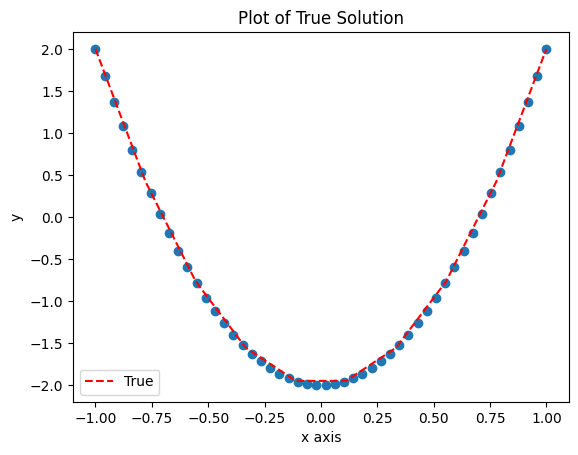

In [13]:
x_min = -1   # lower value of x
x_max = 1   #  upper value of x
N = 50
np.random.seed(2)


# x axis
x = np.random.uniform(low=x_min, high=x_max, size=(N,1))
x = np.linspace(x_min, x_max, N).reshape(N,1)

# true solution
y_true = 4*x**2 -2
xnp = np.linspace(x_min,x_max,10)
ynp = 4*xnp**2 -2


# Ploting
plt.plot(xnp, ynp, 'r--', label="True")
plt.scatter(x, y_true)
plt.xlabel("x axis")
plt.ylabel("y")
plt.legend()
plt.title("Plot of True Solution")
plt.show()

## Neural Network
 PyTorch

In [3]:
class Neural_network(nn.Module):
  def __init__(self,neuron_no):
    super(Neural_network, self).__init__()
    self.input_layer = nn.Linear(1,neuron_no)
    self.hidden_layer1 = nn.Linear(neuron_no,neuron_no)
    self.hidden_layer2 = nn.Linear(neuron_no,neuron_no)
    self.hidden_layer3 = nn.Linear(neuron_no,neuron_no)
    self.output_layer = nn.Linear(neuron_no, 1)

  def forward(self, x):
    x = torch.tanh(self.input_layer(x))
    x = torch.tanh(self.hidden_layer1(x))
    x = torch.tanh(self.hidden_layer2(x))
    x = torch.tanh(self.hidden_layer3(x))
    x = self.output_layer(x)
    return x

In [4]:
Net = Neural_network(20)
Net=Net.to(device)

# ODE Loss

In [5]:
def ode(x, Net):
  x_1 = torch.autograd.Variable( torch.from_numpy(x).float(), requires_grad=True).to(device)

  y = Net.forward(x_1)

  y_x = torch.autograd.grad(y.sum(), x_1, create_graph=True)[0]
  y_xx = torch.autograd.grad(y_x.sum(), x_1, create_graph=True)[0]
  ode = y_xx - 2*x_1*y_x + 4*y
  return ode, y

#Loss and Optimizer

In [6]:
optim = torch.optim.Adam(Net.parameters(), lr=0.001)
LL = nn.MSELoss()

epoch:0, loss:8.04068947, loss_ode:0.01831973
epoch:100, loss:4.70054245, loss_ode:1.24608696
epoch:200, loss:0.97766107, loss_ode:0.18850842
epoch:300, loss:0.15184884, loss_ode:0.08010034
epoch:400, loss:0.01856365, loss_ode:0.01657822
epoch:500, loss:0.02489484, loss_ode:0.02349443
epoch:600, loss:0.01193826, loss_ode:0.01033759
epoch:700, loss:0.00274950, loss_ode:0.00268554
epoch:800, loss:0.00177375, loss_ode:0.00173824
epoch:900, loss:0.01232813, loss_ode:0.01140349
epoch:1000, loss:0.00076314, loss_ode:0.00075062
epoch:1100, loss:0.04695559, loss_ode:0.04200154
epoch:1200, loss:0.00035953, loss_ode:0.00035686
epoch:1300, loss:0.00025535, loss_ode:0.00025328
epoch:1400, loss:0.00021441, loss_ode:0.00021261
epoch:1500, loss:0.00014588, loss_ode:0.00014531
epoch:1600, loss:0.00011756, loss_ode:0.00011723
epoch:1700, loss:0.00018639, loss_ode:0.00017826
epoch:1800, loss:0.00008740, loss_ode:0.00008730
epoch:1900, loss:0.00007881, loss_ode:0.00007875


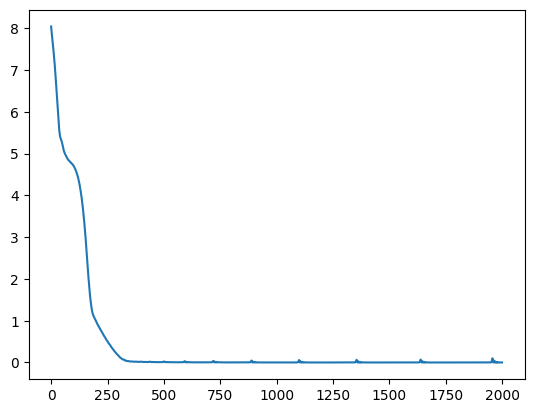

In [7]:
number_of_epoch =2000

loss_value = []
for epoch in range(number_of_epoch):


  loss1 = torch.mean(torch.square( Net.forward( torch.tensor([0.]).to(device) ) - torch.tensor([-2.]).to(device) ))
  loss2 = torch.mean(torch.square( Net.forward( torch.tensor([1.]).to(device) ) - torch.tensor([2.]).to(device) ))
  ode1, _ = ode(x, Net)

  Loss_ode = torch.mean(ode1**2)
  total_loss =  Loss_ode + loss1 + loss2
  total_loss.backward()    # computing gradients using backward propagation  dL/dw
  optim.step()             # This is equivalent to : Weight_new = weight_old - learing_rate * derivative of Loss w.r.t weight
  optim.zero_grad()       # make the gradient zero
  loss_value.append(total_loss.cpu().detach().numpy())
  with torch.autograd.no_grad():
    if epoch%100==0:
      print(f'epoch:{epoch}, loss:{total_loss.item():.8f}, loss_ode:{Loss_ode.item():.8f}' )

plt.plot(loss_value)

## total time need to train

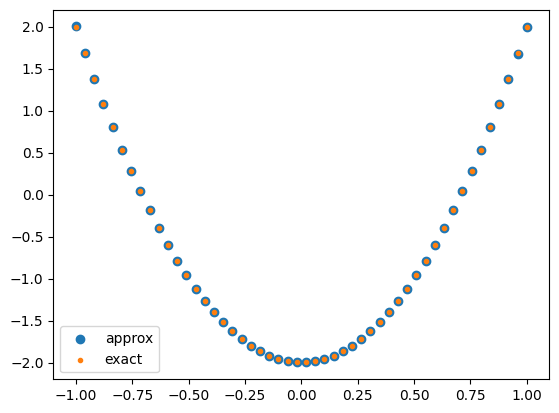

In [14]:
#prediction and plot
plt.scatter(x, ode(x, Net)[1].cpu().detach().numpy(), label="approx")
plt.scatter(x, y_true, label="exact", marker='.')
plt.legend()
plt.show()